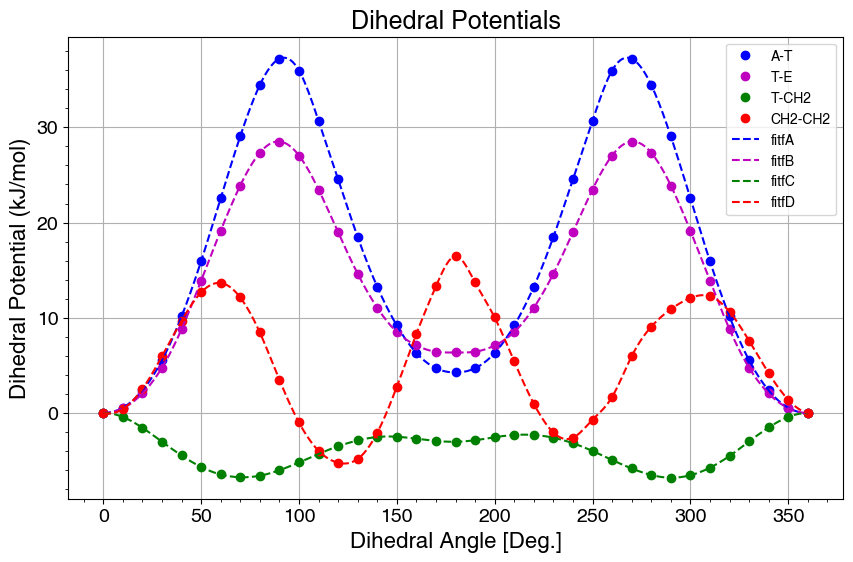

In [8]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad, cumulative_trapezoid
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
import scipy.constants as sc
import random

temperature = 300  # K
kTval = sc.R * temperature / 1000 # kJ/mol
n_repeat_units = 20
# scan for A-D1 to (A-D1)0.7-(A-D2)0.3
prob_values = np.array([1,0.9,0.8,0.7])
n_samples = 50000
# Molecular chain parameters
# The angle order has been changed, which is different from the original logic.
# Labeling starts from the 0th angle. The angle between the [0, 1] bond and the [1, 2] bond is angle[1].
# This makes it more accurate when connecting to the previous unit.
# Rotation label, corresponding to the current bond. 0 means no rotation, 1 means dihedral 1, 2 means dihedral 2, etc.
l1 = [16.338, 1.452, 2.524, 1.434,1.359, 1.434,2.524, 1.452]
Angle1 = np.deg2rad(np.array([-4.06, 4.06, 17.08, 10.37,53.76,-53.76, -10.37, -17.08]))
rotaion1 = [0, 1, 0, 2, 0, 2, 0, 1]
l2= [16.33816, 1.44906,2.508,1.498,1.550, 1.498, 2.508,1.44906]
Angle2= np.deg2rad(np.array([-4.30,4.30,16.61,14.78,67.35,-67.35,-14.78,-16.61,]))
rotaion2 = [0, 1, 0, 3, 4, 3, 0, 1]

# 读取数据文件
def read_data(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    mirrored = np.column_stack((-data[:, 0] + 360, data[:, 1]))
    combined = np.vstack((data, mirrored))
    combined = np.unique(combined, axis=0)
    return combined[np.argsort(combined[:, 0])]

def read_data_no_mirror(file_name):
    data = np.loadtxt(file_name)
    data = np.reshape(data, (-1, 2))
    return data[np.argsort(data[:, 0])]

label_a = 'A-T'
label_b = 'T-E'
label_c = 'T-CH2'
label_d = 'CH2-CH2'
a = read_data(f"{label_a}.txt")
b = read_data(f"{label_b}.txt")
c = read_data_no_mirror(f"{label_c}.txt")
d = read_data_no_mirror(f"{label_d}.txt")
fitfa = interp1d(a[:, 0], a[:, 1], kind='cubic', fill_value="extrapolate")
fitfb = interp1d(b[:, 0], b[:, 1], kind='cubic', fill_value="extrapolate")
fitfc = interp1d(c[:, 0], c[:, 1], kind='cubic', fill_value="extrapolate")
fitfd = interp1d(d[:, 0], d[:, 1], kind='cubic', fill_value="extrapolate")
# Plot the dihedral potentials
plt.figure(figsize=(10, 6))
plt.plot(a[:, 0], a[:, 1], 'bo', label=label_a)
plt.plot(b[:, 0], b[:, 1], 'mo', label=label_b)
plt.plot(c[:, 0], c[:, 1], 'go', label=label_c)
plt.plot(d[:, 0], d[:, 1], 'ro', label=label_d)
x_plot = np.linspace(0, 360, 361)
plt.plot(x_plot, fitfa(x_plot), 'b--', label='fitfA')
plt.plot(x_plot, fitfb(x_plot), 'm--', label='fitfB')
plt.plot(x_plot, fitfc(x_plot), 'g--', label='fitfC')
plt.plot(x_plot, fitfd(x_plot), 'r--', label='fitfD')
plt.xlabel("Dihedral Angle [Deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Potential (kJ/mol)", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.minorticks_on()
plt.title("Dihedral Potentials", fontsize=18, fontfamily="Helvetica")
plt.show()

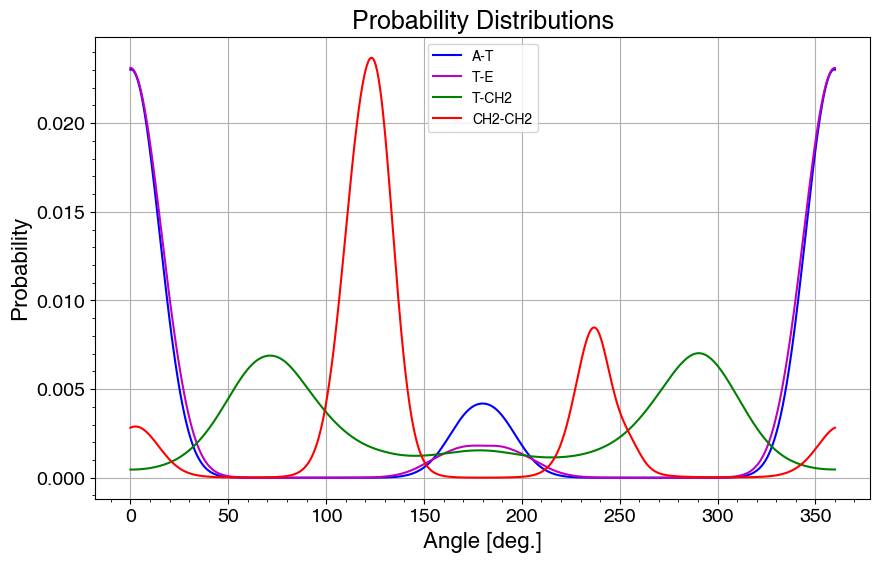

In [9]:
norm_val_a, _ = quad(lambda x: np.exp(-fitfa(x)/kTval), 0, 360)
norm_val_b, _ = quad(lambda x: np.exp(-fitfb(x) / kTval), 0, 360)
norm_val_c, _ = quad(lambda x: np.exp(-fitfc(x) / kTval), 0, 360)
norm_val_d, _ = quad(lambda x: np.exp(-fitfd(x) / kTval), 0, 360)
# Plot probability distributions
x_values = np.linspace(0, 360, 1000)
probA_vals = np.exp(-fitfa(x_values)/kTval) / norm_val_a
probB_vals = np.exp(-fitfb(x_values) / kTval) / norm_val_b
probC_vals = np.exp(-fitfc(x_values) / kTval) / norm_val_c
probD_vals = np.exp(-fitfd(x_values) / kTval) / norm_val_d

plt.figure(figsize=(10, 6))
plt.plot(x_values, probA_vals, 'b-', label=label_a)
plt.plot(x_values, probB_vals, 'm-', label=label_b)
plt.plot(x_values, probC_vals, 'g-', label=label_c)
plt.plot(x_values, probD_vals, 'r-', label=label_d)
plt.xlabel("Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.minorticks_on()
plt.show()

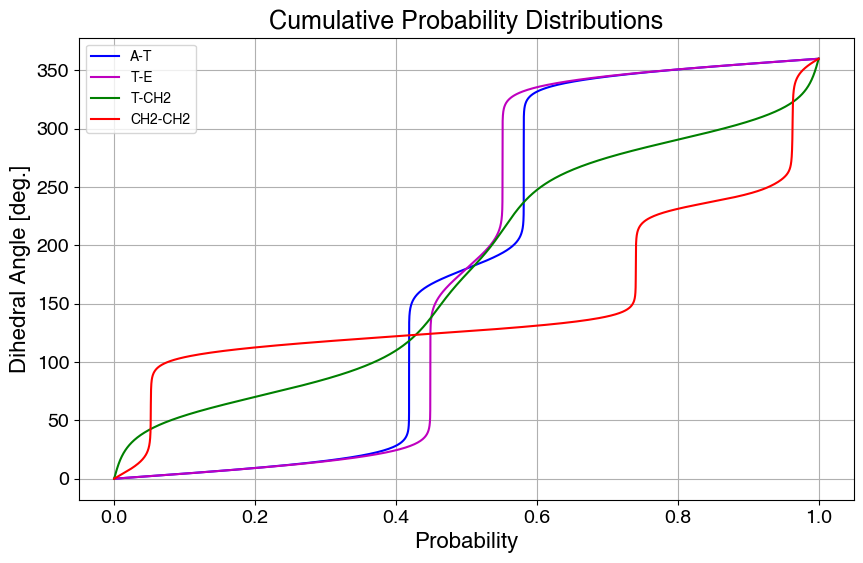

In [10]:
cum_a = cumulative_trapezoid(probA_vals, x_values, initial=0)
cum_b = cumulative_trapezoid(probB_vals, x_values, initial=0)
cum_c = cumulative_trapezoid(probC_vals, x_values, initial=0)
cum_d = cumulative_trapezoid(probD_vals, x_values, initial=0)
th_a = interp1d(cum_a/cum_a[-1], x_values, kind='cubic', fill_value="extrapolate")
th_b = interp1d(cum_b/cum_b[-1], x_values, kind='cubic', fill_value="extrapolate")
th_c = interp1d(cum_c/cum_c[-1], x_values, kind='cubic', fill_value="extrapolate")
th_d = interp1d(cum_d/cum_d[-1], x_values, kind='cubic', fill_value="extrapolate")
plt.figure(figsize=(10, 6))
plt.plot(cum_a/cum_a[-1], x_values, 'b-', label=label_a)
plt.plot(cum_b / cum_b[-1], x_values, 'm-', label=label_b)
plt.plot(cum_c / cum_c[-1], x_values, 'g-', label=label_c)
plt.plot(cum_d / cum_d[-1], x_values, 'r-', label=label_d)
plt.xlabel("Probability", fontsize=16, fontfamily="Helvetica")
plt.ylabel("Dihedral Angle [deg.]", fontsize=16, fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.legend(fontsize=14, prop={'family': 'Helvetica'})
plt.grid(True)
plt.title("Cumulative Probability Distributions", fontsize=18, fontfamily="Helvetica")
plt.show()

In [11]:
def choose_unit(prob1=0.1):
    return random.choices([1, 2], weights=[prob1, 1 - prob1])[0]


def get_unit_params(unit_type):
    if unit_type == 1:
        return l1, Angle1, rotaion1
    else:
        return l2, Angle2, rotaion2


def rotation_matrix(axis, angle):
    axis = np.asarray(axis)
    axis = axis / np.linalg.norm(axis)
    a = np.cos(angle / 2.0)
    b, c, d = -axis * np.sin(angle / 2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])

def dihedralRotate(pts, nb, theta_deg):
    theta_rad = np.deg2rad(theta_deg)
    vec = pts[nb] - pts[nb - 1]
    vec_norm = np.linalg.norm(vec)
    axis = vec / vec_norm
    rot = rotation_matrix(axis, theta_rad)
    pts[nb + 1:] = (pts[nb + 1:] - pts[nb]) @ rot.T + pts[nb]
    return pts


def chain(n, prob1=0.1, rotate=False, cosVal=False):
    if cosVal:
        rotate = True
    all_l = []
    all_Angle = []
    all_rotation = []
    unit_length = []
    unit_types = []
    for _ in range(n):
        unit_type = choose_unit(prob1)
        l_current, Angle_current, rotation_current = get_unit_params(unit_type)
        all_l.append(l_current)
        all_Angle.append(Angle_current)
        all_rotation.append(rotation_current)
        unit_length.append(len(l_current))
        unit_types.append(unit_type)

    # flattern
    flat_l = np.concatenate(all_l)
    flat_Angle = np.concatenate(all_Angle)
    total_length = flat_l.shape[0]

    # full length array
    full_l_array = np.vstack((flat_l, np.zeros((2, total_length)))).T

    # calculate all bond angles and lengths
    angles = np.cumsum(flat_Angle[np.arange(1, total_length)])
    vectors = full_l_array[np.arange(1, total_length)]  # shape (n-1, 3)

    # rotate the bond vectors
    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)
    rotated_x = vectors[:, 0] * cos_angles - vectors[:, 1] * sin_angles
    rotated_y = vectors[:, 0] * sin_angles + vectors[:, 1] * cos_angles
    rotated_z = vectors[:, 2]
    segments = np.column_stack((rotated_x, rotated_y, rotated_z))

    # molecular chain, using cumulative sum of all vectors
    pts = np.cumsum(np.vstack((np.array([[0, 0, 0],
                                         full_l_array[0]]), segments)),
                    axis=0)
    if rotate:
        # rotation occurs at the end of a single bond, so add a 0 point and remove the last point
        flat_rotation = np.append(0, np.concatenate(all_rotation))[:-1]
        k_values = np.arange(0, len(flat_rotation))
        mask_a = flat_rotation == 1
        mask_b = flat_rotation == 2
        mask_c = flat_rotation == 3
        mask_d = flat_rotation == 4
        rand_a = th_a(np.random.rand(mask_a.sum()))
        rand_b = th_b(np.random.rand(mask_b.sum()))
        rand_c = th_c(np.random.rand(mask_c.sum()))
        rand_d = th_d(np.random.rand(mask_d.sum()))
        for k, angle in zip(k_values[mask_a], rand_a):
            dihedralRotate(pts, k, angle)
        for k, angle in zip(k_values[mask_b], rand_b):
            dihedralRotate(pts, k, angle)
        for k, angle in zip(k_values[mask_c], rand_c):
            dihedralRotate(pts, k, angle)
        for k, angle in zip(k_values[mask_d], rand_d):
            dihedralRotate(pts, k, angle)
    if cosVal:
        # each chain is generated independently, so we shall calculate the cosine values after chain generation
        # directly calculate cosine values, otherwise return the chain points and unit lengths
        k_val = np.append(0, np.cumsum(np.array(unit_length))[:-1]) + 2
        vectors = pts[k_val] - pts[k_val - 1]
        v0 = vectors[0]
        dots = vectors @ v0
        norms = np.linalg.norm(vectors, axis=1) * np.linalg.norm(v0)
        return np.clip(dots / norms, -1, 1)
    else:
        return pts, unit_length, unit_types


def drawChain(pts, units, unit_types):
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    pts_array = np.array(pts)
    ax.scatter(pts_array[:, 0],
               pts_array[:, 1],
               pts_array[:, 2],
               s=10,
               c='black')
    num_units = len(units)
    colormap = plt.get_cmap('tab20')
    # darw different colors for different units
    current_index = 0
    for i, unit_length, unit_type in zip(range(num_units), units, unit_types):
        segment_points = pts_array[current_index:current_index + unit_length +
                                   1]
        ax.plot(segment_points[:, 0],
                segment_points[:, 1],
                segment_points[:, 2],
                color=colormap(unit_type),
                linewidth=2)
        current_index += unit_length

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_aspect('equal')
    # ax.view_init(elev=90, azim=0)
    plt.title("Polymer Chain")
    plt.show()

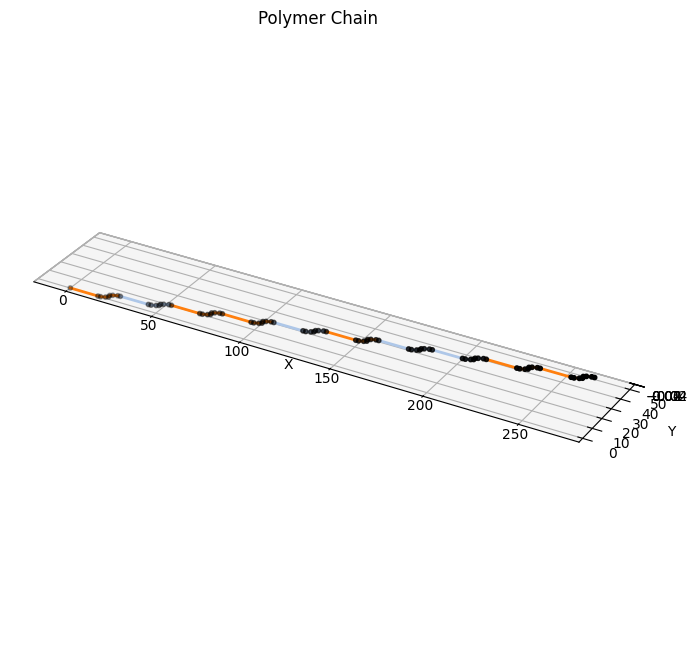

In [12]:
drawChain(*chain(10, prob1=0.5,rotate=False))

In [13]:
def calculate_cos_val(prob_value):
    return chain(n_repeat_units, prob1=prob_value, rotate=True, cosVal=True)
def linear_func(x, a, b):
    return a + b * x
import psutil
from joblib import Parallel, delayed
from scipy.optimize import curve_fit
start_idx = 1
end_idx = 10
n_jobs = psutil.cpu_count(logical=False)
repeat_units = np.arange(n_repeat_units)
all_results = {}
for prob in prob_values:
    print(f"Processing prob = {prob:.2f}")
    cosList2 = Parallel(n_jobs=n_jobs, verbose=1)(delayed(calculate_cos_val)(prob) for _ in range(n_samples))
    corr2 = np.mean(np.array(cosList2), axis=0)
    all_results[prob] = corr2

Processing prob = 1.00


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s
[Parallel(n_jobs=8)]: Done 6640 tasks      | elapsed:    2.2s
[Parallel(n_jobs=8)]: Done 22640 tasks      | elapsed:    7.3s
[Parallel(n_jobs=8)]: Done 45040 tasks      | elapsed:   15.0s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:   16.9s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Processing prob = 0.90


[Parallel(n_jobs=8)]: Done 6640 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 22640 tasks      | elapsed:    9.7s
[Parallel(n_jobs=8)]: Done 45040 tasks      | elapsed:   20.9s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:   23.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Processing prob = 0.80


[Parallel(n_jobs=8)]: Done 6640 tasks      | elapsed:    3.0s
[Parallel(n_jobs=8)]: Done 22640 tasks      | elapsed:    9.6s
[Parallel(n_jobs=8)]: Done 45040 tasks      | elapsed:   19.0s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:   21.0s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  56 tasks      | elapsed:    0.0s


Processing prob = 0.70


[Parallel(n_jobs=8)]: Done 6640 tasks      | elapsed:    2.9s
[Parallel(n_jobs=8)]: Done 22640 tasks      | elapsed:    9.8s
[Parallel(n_jobs=8)]: Done 45040 tasks      | elapsed:   20.4s
[Parallel(n_jobs=8)]: Done 50000 out of 50000 | elapsed:   23.0s finished


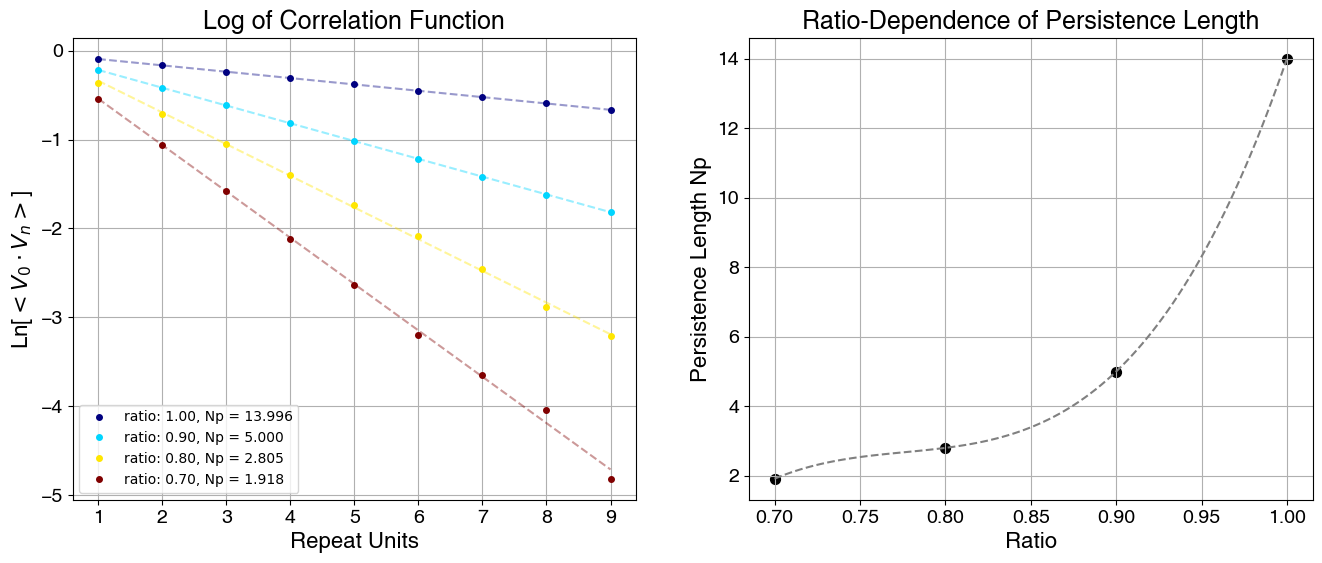

In [14]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.grid(True)
plt.xlabel("Repeat Units", fontsize=16, fontfamily="Helvetica")
plt.ylabel(r'Ln[$<V_0 \cdot V_n>$]',
           fontsize=16,
           fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.title("Log of Correlation Function", fontsize=18, fontfamily="Helvetica")
colormap = plt.get_cmap('jet')
colors = np.linspace(0, colormap.N -1, prob_values.shape[0]).astype(int)
i = 0
all_pl = []
for prob_num, corr2_array in all_results.items():
    popt, pcov = curve_fit(linear_func, repeat_units[start_idx:end_idx], np.log(corr2_array[start_idx:end_idx]))
    logFit_prime = popt[1]
    persistence_length = -1 / logFit_prime
    all_pl.append(persistence_length)
    plt.plot(repeat_units[start_idx:end_idx],
            np.log(corr2_array[start_idx:end_idx]),
            marker='o',
            markersize=4,
            color=colormap(colors[i]),linestyle='',
            label=f'ratio: {prob_num:.2f}, Np = {persistence_length:.3f}')
    plt.plot(repeat_units[start_idx:end_idx],
            linear_func(repeat_units[start_idx:end_idx], *popt),
            linestyle='dashed', alpha=0.4,color=colormap(colors[i]) )
    i += 1
plt.legend()
plt.subplot(1, 2, 2)
plt.grid(True)
plt.xlabel("Ratio", fontsize=16, fontfamily="Helvetica")
plt.ylabel('Persistence Length Np',
           fontsize=16,
           fontfamily="Helvetica")
plt.xticks(fontsize=14, fontfamily="Helvetica")
plt.yticks(fontsize=14, fontfamily="Helvetica")
plt.title("Ratio-Dependence of Persistence Length", fontsize=18, fontfamily="Helvetica")
plt.scatter(prob_values, all_pl, marker='o', s=50, color='black')
fit_pl = interp1d(prob_values, all_pl, kind='cubic')
ratio_values = np.linspace(0.7, 1, 100)
plt.plot(ratio_values, fit_pl(ratio_values), color='gray', linestyle='dashed')
plt.show()